In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from pylab import rcParams
from scipy.ndimage.interpolation import rotate, zoom
import scipy as sp
import cv2
%matplotlib inline
import sys
from tqdm import tqdm
import argparse
from IPython.display import clear_output

sys.path.append("/home/msmith/misc/pcaRotate/") # Helper function
from pcaRotate import main as rotate
from pcaRotate import getRed
from pylab import rcParams
rcParams["figure.figsize"] = 30,25


def show():
    plt.title(wp)
    plt.subplot(161)
    plt.imshow(orig)
    plt.subplot(162)
    plt.imshow(mask)
    plt.subplot(163)
    plt.imshow(maskRot,cmap=cm.gray)
    plt.subplot(164)
    plt.imshow(red,cmap=cm.gray)
    #plt.subplot(165)
    #plt.imshow(origRot)
    plt.subplot(165)
    plt.imshow(croppedHead)
    plt.show()

  0%|          | 0/11468 [00:00<?, ?it/s]

Make sure image is in RGB order not BGR


  0%|          | 38/11468 [00:35<2:08:58,  1.48it/s]

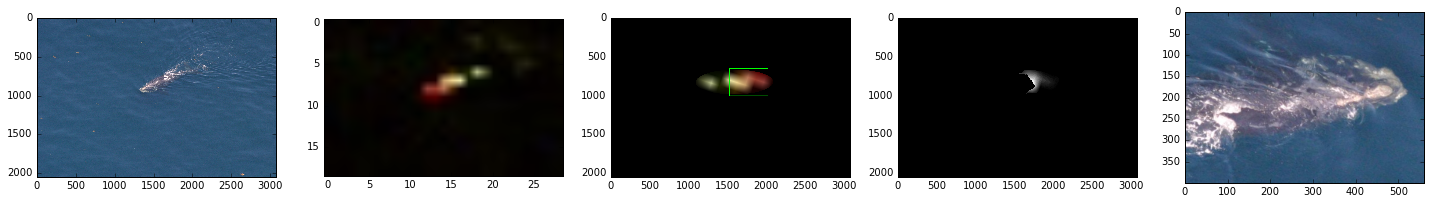

  0%|          | 39/11468 [00:37<3:24:04,  1.07s/it]

In [ ]:
if __name__ == "__main__": 
    
    ss = 0
    if ss == 1:
        maskPath = "m1_ss_"
        dstPath = "head_ss_"
        ext = "ss_"
    else:
        maskPath = "m1_"
        dstPath = "head_"
        ext = "[0-9]"
    
    imgPaths = glob.glob("/home/msmith/kaggle/whale/imgs/whale*/m1_{0}*".format(ext))
    testPaths = glob.glob("/home/msmith/kaggle/whale/imgs/test*/m1_{0}*".format(ext))
    print("Make sure image is in RGB order not BGR")
    imgPaths.sort()
    imgPaths += testPaths

    cantSave = []
    linAlgError = []
    aspectRatio = 1.4
    h = 400
    w = int(h*aspectRatio)
    count = 0
    for path in tqdm(imgPaths):
        
        try:
            orig, mask = [cv2.imread(x)[:,:,::-1] for x in [path.replace(maskPath,"w1_"),path]]
            croppedHead, maskRot, red = rotate(orig=orig,mask=mask,ellipseThresh=10,redThresh=[0.08,0.13],cntThresh=0.01,pad=20,aspectRatio=aspectRatio)

            wp = path.replace(maskPath,dstPath)

            if croppedHead.size == 0:
                print("couldn't save {0}".format(wp))
                cantSave.append(wp)
                show()
            else:
                croppedHead = cv2.resize(croppedHead,(w,h),interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(wp,croppedHead)
                #print(wp)

            if np.random.uniform() < 0.01:
                show()
                count += 1

            if count == 10:
                clear_output()
                count = 0
        except np.linalg.linalg.LinAlgError as err:
            linAlgError.append(path)